In [1]:
%matplotlib inline
import rasterio
import geopandas as gpd
import pandas as pd
from tkinter import Tk, filedialog, simpledialog, messagebox
import rioxarray as rxr
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import geoplot as gplt
import contextily as ctx
import plotly.express as px
import numpy as np

In [2]:
import ee
import geemap
try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

In [3]:
root = Tk() # pointing root to Tk() to use it as Tk() in program.
root.withdraw() # Hides small tkinter window.
root.attributes('-topmost', True) # Opened windows will be active. above all windows despite of selection.
roi_directory = filedialog.askopenfile(title = "Open RoI Shapefile") 
peat_directory = filedialog.askopenfile(title = "Open Peatland Shapefile")

In [4]:
# specify project name
projectname = simpledialog.askstring("Input", "Speficy project name",parent=root)

if projectname is not None:
    print("The script will assess ", projectname)
else:
    print("Name has not been submitted, Restart the code!")
    
#Specify Projection
projection = simpledialog.askstring("Input", "Specify Projection in UTM zone, example EPSG:3857", parent=root)

if projection is not None:
    print("All data will be reprojected to ", projection, ' canopy cover')
else:
    print("Projection has not specified, Restart the code!")
    
# column name for roi id
roi_column_name = simpledialog.askstring("Input", "Specify columns name in ROI attribute table to define boundary name",parent=root)

if roi_column_name is not None:
    print("Column name is ", roi_column_name)
else:
    print("Column has not identified, Restart the code!")

The script will assess  Test_GlobPeat
All data will be reprojected to  EPSG:32733  canopy cover
Column name is  name


In [5]:
# specify for Hansen

#Specify forest_threshold
forest_threshold = simpledialog.askinteger("Input", "Specify forest threshold value to define forest",parent=root , 
                                           minvalue =0, maxvalue = 100)

if forest_threshold is not None:
    print("Forest is defined as area with >= ", forest_threshold, ' canopy cover')
else:
    print("Forest Threshold has not specified, Restart the code!")
    
# Specify minimum mapping unit - forest
min_forest_map_area = simpledialog.askinteger("Input", "Specify Min pixels area, example: 22 pixels = 2 Ha or 6 pixels = 0.5 Ha",
                                              parent=root , minvalue =0, maxvalue = 100)

if min_forest_map_area is not None:
    print("Minimum pixels size is ", min_forest_map_area)
else:
    print("Minimum pixels size has not identified, Restart the code!")

pixels = ee.Number(min_forest_map_area)
    
# Specify minimum mapping unit - forest loss
min_forestloss_map_area = simpledialog.askinteger("Input", "Specify Min pixels area, example: 22 pixels = 2 Ha or 6 pixels = 0.5 Ha",
                                                  parent=root , minvalue =0, maxvalue = 100)

if min_forestloss_map_area is not None:
    print("Minimum pixels size is ", min_forestloss_map_area)
else:
    print("Minimum pixels size has not identified, Restart the code!")

lossPixels = ee.Number(min_forestloss_map_area); 



Forest is defined as area with >=  10  canopy cover
Minimum pixels size is  6
Minimum pixels size is  6


In [6]:
# tile scale to avoid memory ran out issue
tileScale = 4

In [7]:
# roi shapefile
roi = gpd.read_file(roi_directory.name)
peat = gpd.read_file(peat_directory.name)

# reproject to UTM
roi_proj  = roi.to_crs(crs = projection)
peat_proj = peat.to_crs(crs = projection)

In [8]:
# clip peatland by roi then union with roi to create peat and non-peat
# peat : 1
# non-peat: 0
peat_roi_proj = gpd.clip(peat_proj, roi_proj)
peat_roi_proj["Data"] = 1
peat_nonpeat_roi_proj = gpd.overlay(roi_proj, peat_roi_proj, how = "union")

In [12]:
# calculate peat and non-peat area
peat_nonpeat_roi_proj["Area_Ha"] = peat_nonpeat_roi_proj['geometry'].area/10000
peat_nonpeat_roi_proj.Data = peat_nonpeat_roi_proj.Data.fillna(2)
peat_nonpeat_roi_proj.Data = peat_nonpeat_roi_proj.Data.astype("int64")

In [15]:
# create new ID
peat_nonpeat_roi_proj['new_id'] = np.arange(len(peat_nonpeat_roi_proj))

In [16]:
# Convert to ee.FeatureCollection for calculation process
peat_nonpeat_roi_proj_gee = geemap.geopandas_to_ee(peat_nonpeat_roi_proj, geodesic=False)

In [45]:
# rasterize ee.FeatureCollection to Image
peat_nonpeat_roi_proj_gee_raster = peat_nonpeat_roi_proj_gee \
  .filter(ee.Filter.notNull(['Data'])) \
  .reduceToImage(**{
    'properties': ['Data'],
    'reducer': ee.Reducer.first()
})

In [46]:
# Import Hansen image dataset
Hansen = ee.Image("UMD/hansen/global_forest_change_2021_v1_9")
primaryForests = ee.ImageCollection("UMD/GLAD/PRIMARY_HUMID_TROPICAL_FORESTS/v1").mosaic().selfMask();

# Select bands
treeCover = Hansen.select(['treecover2000']);
lossImage = Hansen.select(['loss']);
gainImage = Hansen.select(['gain']);
lossImage_year = Hansen.select(['lossyear']);
landmask = Hansen.select(['datamask']);

In [47]:
# Reproject Image to UTM
treeCover_proj = treeCover.reproject(crs = projection, scale = 30)
lossImage_proj = lossImage.reproject(crs = projection, scale = 30)
lossImage_year_proj = lossImage_year.reproject(crs = projection, scale = 30)
landmask_proj = landmask.reproject(crs = projection, scale = 30)
primaryForests_proj = primaryForests.reproject(crs = projection, scale = 30)

In [79]:
# 1. Primary Forest 2001
primaryForestContArea = primaryForests_proj.connectedPixelCount();
# Apply the minimum area on primary forest
primaryForestMinArea = primaryForestContArea.gte(pixels)#.selfMask();

In [80]:
# 2 Forest Map in 2000 (Non-primary forest 2000)
# 2.1 Define forest area by >= canopy cover
forest_canopy = treeCover_proj.gte(forest_threshold);

# 2.2 Define non-primary forest from pirmary forest dataset
primaryForestUnmask = primaryForestMinArea.unmask();
primaryForestEq0 = primaryForestUnmask.select('Primary_HT_forests').eq(0);

# 2.3 Mask forest canopy cover threshold with nonprimary forest
forestCC = forest_canopy.updateMask(forest_canopy.eq(1)).updateMask(landmask_proj.eq(1)).updateMask(primaryForestEq0);

# 2.4 Apply smoothing
forestContArea = forestCC.connectedPixelCount();
forestMinArea = forestContArea.gte(pixels)#.selfMask();

In [81]:
# 3 Accumulated Forest loss 2001-2021:

# 3.1 Accumulated Forest Loss in non-primary forest loss
# 3.1.1 Estimate forest loss in forest 2000 >= Canopy cover
maskerforestLoss = lossImage_year_proj.gte(1);
forestLoss = lossImage_proj .updateMask(forestCC.eq(1)).updateMask(landmask_proj.eq(1)).updateMask(maskerforestLoss);
## Create a contiguous area.
contLoss = forestLoss.connectedPixelCount();
minLoss = contLoss.gte(lossPixels)#.selfMask();

# 3.2 Accumulated Forest Loss 2002-2021 in Primary Forest
# 3.2.1 Estimate forest loss exclusively in primary forest
MaskedPrimaryLoss= lossImage_year_proj.gte(2); ##// loss between 2002-2021
primaryLoss = lossImage_year_proj.updateMask(MaskedPrimaryLoss).updateMask(primaryForestMinArea).updateMask(landmask_proj.eq(1))
# 3.2.2 primary loss filtered by min mapping area
contPrimaryLoss= primaryLoss.connectedPixelCount();
minPrimaryLoss = contPrimaryLoss.gte(lossPixels)#.selfMask();

In [82]:
# 4 Annual Forest Loss 2001-2021
# 4.1 Non-primary forest
AnnualTreeLoss = lossImage_year_proj.updateMask(forestMinArea.eq(1)).updateMask(landmask_proj.eq(1))
## Create a contiguous area.
contAnnualLoss = AnnualTreeLoss.connectedPixelCount();
minAnnualLoss = contAnnualLoss.gte(lossPixels)#.selfMask();
minAnnualloss_masked = lossImage_year_proj.updateMask(minAnnualLoss)

# 4.2 Primary Forest
annual_PrimaryLoss = lossImage_year_proj.updateMask(primaryForestMinArea.eq(1)).updateMask(landmask_proj.eq(1)).updateMask(MaskedPrimaryLoss.eq(1))
##** var primaryForestLoss = primaryLoss.updateMask(primaryForestMinArea);
##** Create contiguous area within primary forest loss
contAnnualPrimaryLoss = annual_PrimaryLoss.connectedPixelCount();
minAnnualPrimaryLoss = contAnnualPrimaryLoss.gte(lossPixels)#.selfMask();
minAnnualPrimaryLoss_masked = annual_PrimaryLoss.updateMask(minAnnualPrimaryLoss)

In [83]:
# 5. Primary Forest 2022
# Use nonLoss mask to define the non deforested area in forest map >= canopy cover
PrimaryMinLossUnmask = minPrimaryLoss.unmask();
PrimaryNotLoss = PrimaryMinLossUnmask.select('lossyear').eq(0);
PrimaryForestCover22 = primaryForestMinArea.updateMask(PrimaryNotLoss);

In [84]:
# 6 Forest Map in 2022
# Use nonLoss mask to define the non deforested area in forest map >= canopy cover
minLossUnmask = minLoss.unmask();
notLoss = minLossUnmask.select('loss').eq(0);
primaryForestUnmask = primaryForestMinArea.unmask();
notprimaryForest = primaryForestUnmask.select('Primary_HT_forests').eq(0);
forestCover22 = forestMinArea .updateMask(notLoss).updateMask(notprimaryForest);

In [85]:
# clip raster by roi, buffer 3km, buffer 10km to avoid error
# 1. Forest 2000 and 2022
FNF_00_Final = forestMinArea.clip(peat_nonpeat_roi_proj_gee)
FNF_22_Final = forestCover22.clip(peat_nonpeat_roi_proj_gee)

# 2. Primary Forest 2000
PF_00_Final = primaryForestMinArea.clip(peat_nonpeat_roi_proj_gee)
PF_22_Final = PrimaryForestCover22.clip(peat_nonpeat_roi_proj_gee)

# 3. Annual Forest Loss 2001-2022
Annual_FL_01_21_Final = minAnnualloss_masked.clip(peat_nonpeat_roi_proj_gee)

# 4. Annual Primary Forest Loss 2001-2022
Annual_PFL_01_21_Final = minAnnualPrimaryLoss_masked.clip(peat_nonpeat_roi_proj_gee)

In [75]:
primaryForestMinArea.getInfo()

{'type': 'Image',
 'bands': [{'id': 'Primary_HT_forests',
   'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 1},
   'crs': 'EPSG:32733',
   'crs_transform': [30, 0, 0, 0, -30, 0]}]}

In [86]:
# Visualization Parameters
# Forest 2000- Green
vis_treecover = {'palette': ['000000', '00FF00'], 'max': 100};
# Accumulated Forest Loss 2001-2020
vis_loss = {'palette': ['FF0000']};
# Annual forest loss 2001-2020
vis_loss_year = {'palette': ['blue', 'red'], 'min':1, 'max': 21};
vis_prim_loss_year = {'palette': ['blue', 'yellow', 'red'], 'min':2, 'max': 21};
# Forest non forest map
vis_forestnonforest = {'palette': ['yellow','#008000'], 'min':0, 'max':1};

# roi polygon
vis_roi = {'color': '#FF0000', 'width': 2,'lineType': 'solid','fillColor': '00000000'}

In [88]:
Map = geemap.Map()

Map.centerObject(peat_nonpeat_roi_proj_gee, 10)
# 1. RoI and buffer
Map.addLayer(peat_nonpeat_roi_proj_gee.style(**vis_roi), {}, "Region of Interest")
Map.addLayer(peat_nonpeat_roi_proj_gee_raster, {} ,'RoI_raster')
# 2 Forest in 2000
Map.addLayer(forestMinArea.clip(peat_nonpeat_roi_proj_gee), vis_forestnonforest, "Forest/Non-forest 2000")
Map.addLayer(primaryForestMinArea.clip(peat_nonpeat_roi_proj_gee), vis_forestnonforest, 'Primary Forest 2001')
# 3 Forest Loss in 2001 -2021
Map.addLayer(minLoss.clip(peat_nonpeat_roi_proj_gee), vis_loss_year, "Accumulated Forest Loss 2001-2021")
Map.addLayer(minPrimaryLoss.clip(peat_nonpeat_roi_proj_gee), vis_loss_year, "Accumulated Forest Loss in Primary Forest 2001-2021")
Map.addLayer(minAnnualloss_masked.clip(peat_nonpeat_roi_proj_gee), vis_loss_year, "Annual Forest Loss 2001-2021", False)
Map.addLayer(minAnnualPrimaryLoss_masked.clip(peat_nonpeat_roi_proj_gee), vis_loss_year, 'Annual Primary Forest Loss 2001-2021', False)

# 4. Forest in 2022
#Map.addLayer(forestCover22.clip(peat_nonpeat_roi_proj_gee), vis_forestnonforest, 'Forest/Non-forest 2022',False)
#Map.addLayer(PrimaryForestCover22.clip(peat_nonpeat_roi_proj_gee), vis_forestnonforest, 'Primary Forest 2022',False)

# 5. global
#Map.addLayer(minAnnualloss_masked, vis_loss_year, "Global Annual Forest Loss 2001-2021", False)
#Map.addLayer(primaryForestMinArea, vis_forestnonforest, 'global primary forest 2001')
#Map.addLayer(minAnnualPrimaryLoss_masked, vis_loss_year, 'global annual primary forest loss 2001-2022')

Map

Map(center=[-1.872034839775491, 15.874683243836692], controls=(WidgetControl(options=['position', 'transparent…

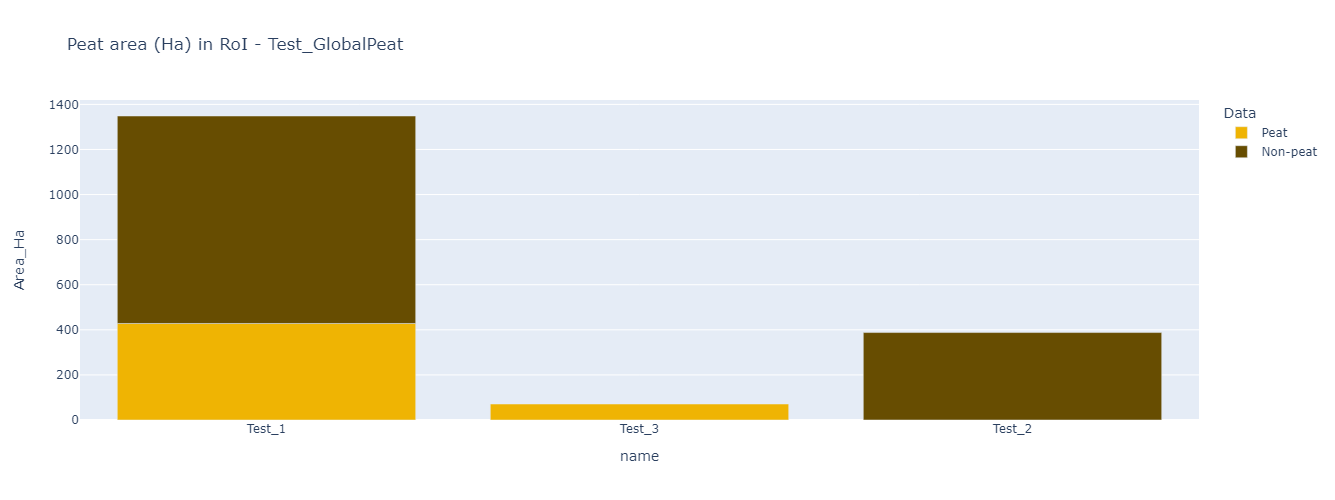

In [60]:
# Peat area in RoI
fig_peatarea = px.bar(peat_nonpeat_roi_proj, x = peat_nonpeat_roi_proj[roi_column_name],
                      y =peat_nonpeat_roi_proj.Area_Ha, color = 'Data',
                      category_orders={"Peat Map": ["Peat", "Non-peat"]},
                      color_discrete_sequence = ['#efb403', '#674d01'],
                      width=1400, height=500, 
                   title ="Peat area (Ha) in RoI - " + projectname)
fig_peatarea

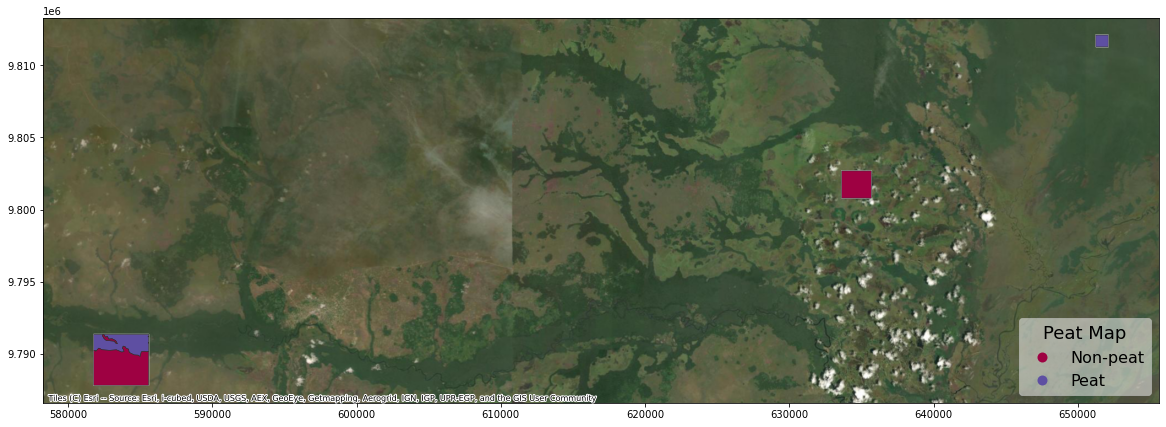

In [55]:
fig_peat, ax_peat= plt.subplots(figsize=(20,20))
#ax_peat.add_artist(ScaleBar(1, box_alpha=0.6, location = 'lower right'))
ax_peat = roi_proj.plot(color = None, edgecolor = 'white', facecolor="none", ax = ax_peat)
ax_peat = peat_nonpeat_roi_proj.plot(column='Data', categorical=True, cmap = 'Spectral', linewidth=.6, edgecolor='0.2',
                                     legend=True, 
                                    legend_kwds={'fontsize':16,'frameon':False, 'loc': 'lower right', 'title' : 'Peat Map', 'title_fontsize' : 18, 'frameon': True, 'framealpha':0.5}, 
                                     ax = ax_peat)
ax_peat = ctx.add_basemap(source=ctx.providers.Esri.WorldImagery, crs=peat_nonpeat_roi_proj.crs.to_string(), ax = ax_peat)